# Does mentioning tipping in the prompt make LLMs give better answers? If it does, does the amount matter?

## Introduction

In a recent [Twitter post](https://twitter.com/voooooogel/status/1730726744314069190), a user argued that large language models may perform better when offering a small tip. This is a very interesting phenomenon, as it seems to suggest LLMs also learned some of the cultures from training. In this notebook, I will be experimenting on this topic. First I will compare whether tip and tip amount matter on different existing LLMs. Then, since LLMs such as GPT and Claude offer a system variable which controls model's behavior, I will also test whether different role assigned to LLMs will also have an impact on how tip will affect their answers. 

## Methods

There are a lot of way to test the quality of the response. In this notebook, I will use the number of tokens produced in response to represent the quality of the response. The larger the number, the better the results.

## Experiment

### Randomness

Since all LLMs are statistcal models, the answers they generate are random as well. Setting the random seed for all the responses helps with the reproducibility of the result.

However, Claude and Gemini do not have the functionality to apply seed for the output generated.

In [40]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
random.seed(555)
random_seeds = [random.randint(0, 5000)for i in range(5)]
random_seeds

[1583, 2249, 1319, 1050, 4597]

### Questions

In [4]:
# A list of question that will be used as prompt
questions = ["Can you explain to me in detail how transformer architecture works?, I will not tip you.",
             "Can you explain to me in detail how transformer architecture works?",
             "Can you explain to me in detail how transformer architecture works? I will tip you 1 cent after you anwsered.",
             "Can you explain to me in detail how transformer architecture works? I will tip you 10 cents after you anwsered.",
             "Can you explain to me in detail how transformer architecture works? I will tip you 1 dollar after you anwsered.",
             "Can you explain to me in detail how transformer architecture works? I will tip you 100 dollars after you anwsered.",
             "Can you explain to me in detail how transformer architecture works? I will tip you 1000000 dollars after you anwsered."]

### Model: GPT

In [6]:
from openai import OpenAI

In [5]:
# funtion for getting responses from api call
def get_responses_gpt(q_list:list, model:str, num_choices:int=1, seed:int=None):
    client = OpenAI()
    responses = []
    for question in q_list:
        response = client.chat.completions.create(
            model = model,
            messages = [
                {'role':'user', 'content':question}
            ],
            n = num_choices,
            seed = seed
        )
        responses.append(response)
    
    return responses

In [11]:
# function for calling older gpt versions
def get_responses_gpt_legacy(q_list:list, model:str, num_choices:int=1, seed:int=None):
    client = OpenAI()
    responses = []
    for question in q_list:
        response = client.completions.create(
            model=model,
            prompt=question,
            n=num_choices,
            max_tokens=500,
            seed=seed
        )
        responses.append(response)
    
    return responses

In [12]:
# function for calculating average response tokens
def calculate_avg_token_gpt(responses_list:list, num_choices:int):
    avg_token_list = []
    for r in responses_list:
        total_token = r.usage.completion_tokens
        avg_token = total_token/num_choices
        avg_token_list.append(avg_token)
    return avg_token_list

### Test on current models

In [14]:
responses_gpt = get_responses_gpt(questions, 'gpt-3.5-turbo', num_choices=5)

In [15]:
calculate_avg_token_gpt(responses_gpt, num_choices=5)

[350.0, 447.0, 364.8, 391.4, 377.6, 430.4, 357.8]

### Test on legacy models

In [10]:
responses_gpt_legacy = get_responses_gpt_legacy(questions, 'davinci-002', num_choices=5)

In [17]:
calculate_avg_token_gpt(responses_gpt_legacy, num_choices=5)

[268.8, 321.6, 327.4, 252.6, 215.4, 438.2, 377.0]

### Get the results

For each version of gpt models, I will get five response for each question and test on five different seeds, which results in 25 responses for each question asked. The average token produced will be calculated for each question.

In [30]:
models = ['gpt-3.5-turbo-16k', 'gpt-3.5-turbo', 'gpt-4-turbo-preview']
legacy_models = ['davinci-002', 'gpt-3.5-turbo-instruct']

In [37]:
# Create a dictionary to hold the results
gpt_result_dict = {}

# Loop through all the models
num_choices = 5

for m in models:
    all_responses_tokens = []
    for seed in random_seeds:
        responses = get_responses_gpt(questions, m, num_choices, seed)
        avg_tokens = calculate_avg_token_gpt(responses, num_choices)
        all_responses_tokens.append(avg_tokens)
    all_responses_tokens_np = np.array(all_responses_tokens)
    average_token_list = np.average(all_responses_tokens_np, axis=0)
    gpt_result_dict[m] = average_token_list

for m in legacy_models:
    all_responses_tokens = []
    for seed in random_seeds:
        responses = get_responses_gpt_legacy(questions, m, num_choices, seed)
        avg_tokens = calculate_avg_token_gpt(responses, num_choices)
        all_responses_tokens.append(avg_tokens)
    all_responses_tokens_np = np.array(all_responses_tokens)
    average_token_list = np.average(all_responses_tokens_np, axis=0)
    gpt_result_dict[m] = average_token_list

In [38]:
gpt_result_dict

{'gpt-3.5-turbo-16k': array([622.68, 659.68, 577.76, 573.8 , 607.56, 647.4 , 605.88]),
 'gpt-3.5-turbo': array([329.44, 470.48, 331.68, 335.28, 367.24, 401.88, 394.48]),
 'gpt-4-turbo-preview': array([780.84, 799.52, 767.24, 782.2 , 779.  , 822.16, 765.12]),
 'davinci-002': array([336.24, 347.32, 276.  , 275.76, 265.72, 284.56, 301.04]),
 'gpt-3.5-turbo-instruct': array([496.92, 500.  , 492.6 , 493.84, 500.  , 500.  , 498.48])}

In [45]:
gpt_result_df = pd.DataFrame(gpt_result_dict, index=['No tip', 'Baseline', '1 cent', '10 cents', '1 dollar', '100 dollars', '1000000 dollars'])
gpt_result_df

,gpt-3.5-turbo-16k,gpt-3.5-turbo,gpt-4-turbo-preview,davinci-002,gpt-3.5-turbo-instruct
No tip,622.68,329.44,780.84,336.24,496.92
Baseline,659.68,470.48,799.52,347.32,500.00
1 cent,577.76,331.68,767.24,276.00,492.60
10 cents,573.80,335.28,782.20,275.76,493.84
1 dollar,607.56,367.24,779.00,265.72,500.00
100 dollars,647.40,401.88,822.16,284.56,500.00
1000000 dollars,605.88,394.48,765.12,301.04,498.48


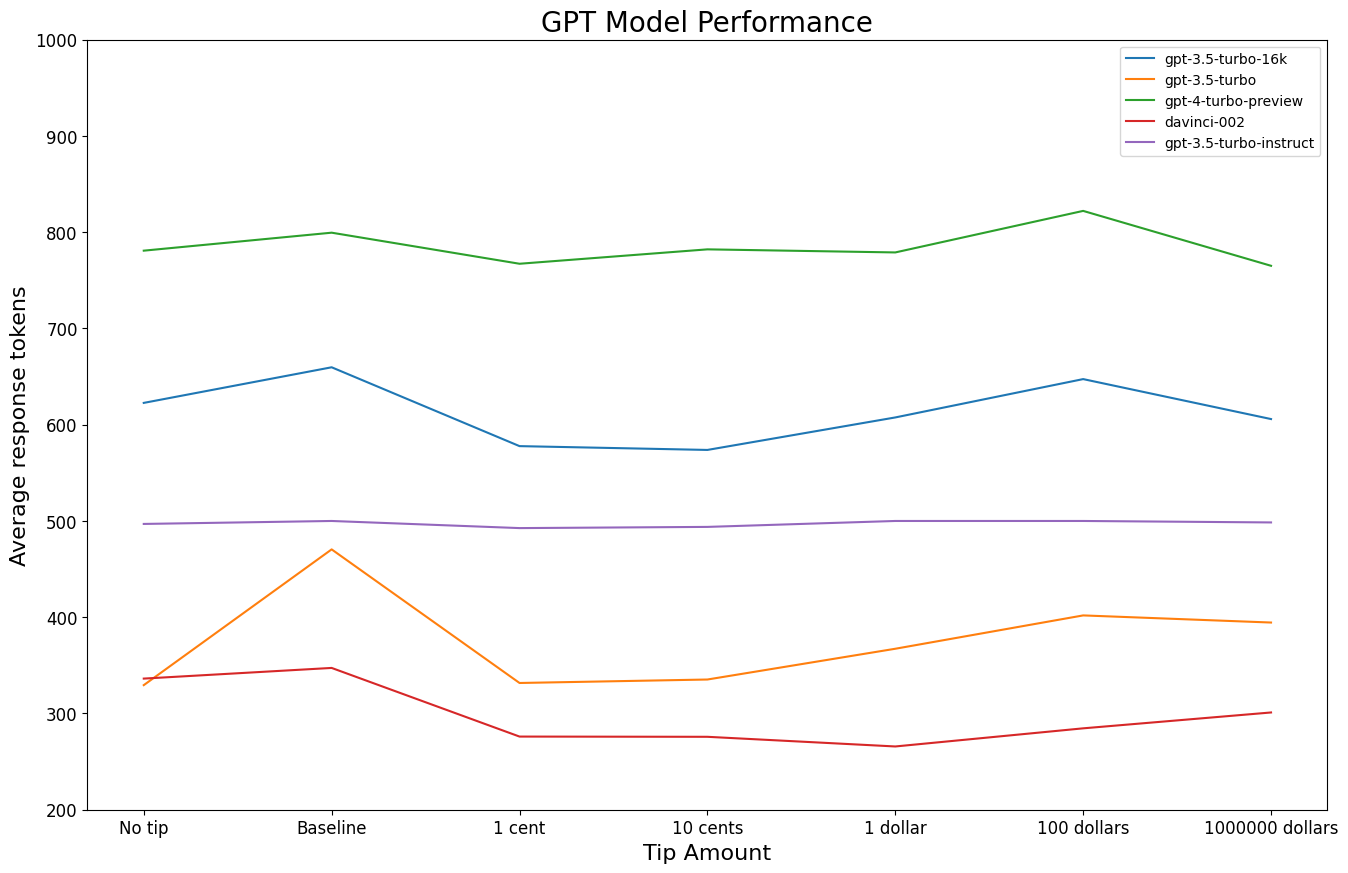

In [63]:
plt.figure(figsize=(16, 10))
plt.plot(gpt_result_df)
plt.title('GPT Model Performance', fontsize=20)
plt.legend(gpt_result_df.columns, loc='upper right')
plt.xticks(fontsize=12)
plt.xlabel('Tip Amount', fontsize=16)
plt.ylim(200, 1000)
plt.yticks(fontsize=12)
plt.ylabel('Average response tokens', fontsize=16);

For gpt models, despite the difference between each model's performance, across all models, there is not a significant differece between the quality of output. There is a drop in number of token produced if 'no tip' is mentioned compare to just asking the question. There is also a slight increaing trend from giving 1 cent of tip to 100 dollars. It is interesting that compare to not giving any tip, giving just 1 cent actaually dropped the performance of all gpt models. For better and newer models such as gpt-3.5 and gpt-4, there is a decrease when tip amount increases from 100 to a million. 

### Model: Claude

In [119]:
from anthropic import Anthropic

In [120]:
def get_responses_claude(q_list:list, model:str, num_answers:int=1):
    client_claude = Anthropic()
    responses = []
    for question in q_list:
        messages = []
        for i in range(num_answers):
            message = client_claude.messages.create(
                model=model,
                messages=[
                    {"role": "user", "content": question}
                ],
                max_tokens=1024,
            )
            messages.append(message)
            
        responses.append(messages)
    return responses

In [121]:
# function for calculating average response tokens
def calculate_avg_token_claude(responses_list:list, num_answers:int):
    avg_token_list = []
    for messages in responses_list:
        total_output_token = 0
        for m in messages:
            total_output_token += m.usage.output_tokens
        avg_token = total_output_token / num_answers
        avg_token_list.append(avg_token)
    return avg_token_list

In [138]:
claude_result_dict = {}
num_answers = 1

# Claude 3 Models
models_3 = ['claude-3-opus-20240229', 'claude-3-sonnet-20240229', 'claude-3-haiku-20240307']
for m in models_3:
    response_list_claude = get_responses_claude(questions, m, num_answers)
    response_tokens_claude = calculate_avg_token_claude(response_list_claude, num_answers)
    avg_tokens_list_claude = np.array(response_tokens_claude)
    claude_result_dict[m] = avg_tokens_list_claude

In [139]:
claude_result_dict

{'claude-3-opus-20240229': array([882., 778., 872., 863., 866., 796., 832.]),
 'claude-3-sonnet-20240229': array([697., 815., 799., 754., 835., 813., 770.]),
 'claude-3-haiku-20240307': array([646., 672., 664., 641., 738., 702., 711.])}

In [140]:
claude_result_df = pd.DataFrame(claude_result_dict, index=['No tip', 'Baseline', '1 cent', '10 cents', '1 dollar', '100 dollars', '1000000 dollars'])
claude_result_df

,claude-3-opus-20240229,claude-3-sonnet-20240229,claude-3-haiku-20240307
No tip,882.0,697.0,646.0
Baseline,778.0,815.0,672.0
1 cent,872.0,799.0,664.0
10 cents,863.0,754.0,641.0
1 dollar,866.0,835.0,738.0
100 dollars,796.0,813.0,702.0
1000000 dollars,832.0,770.0,711.0


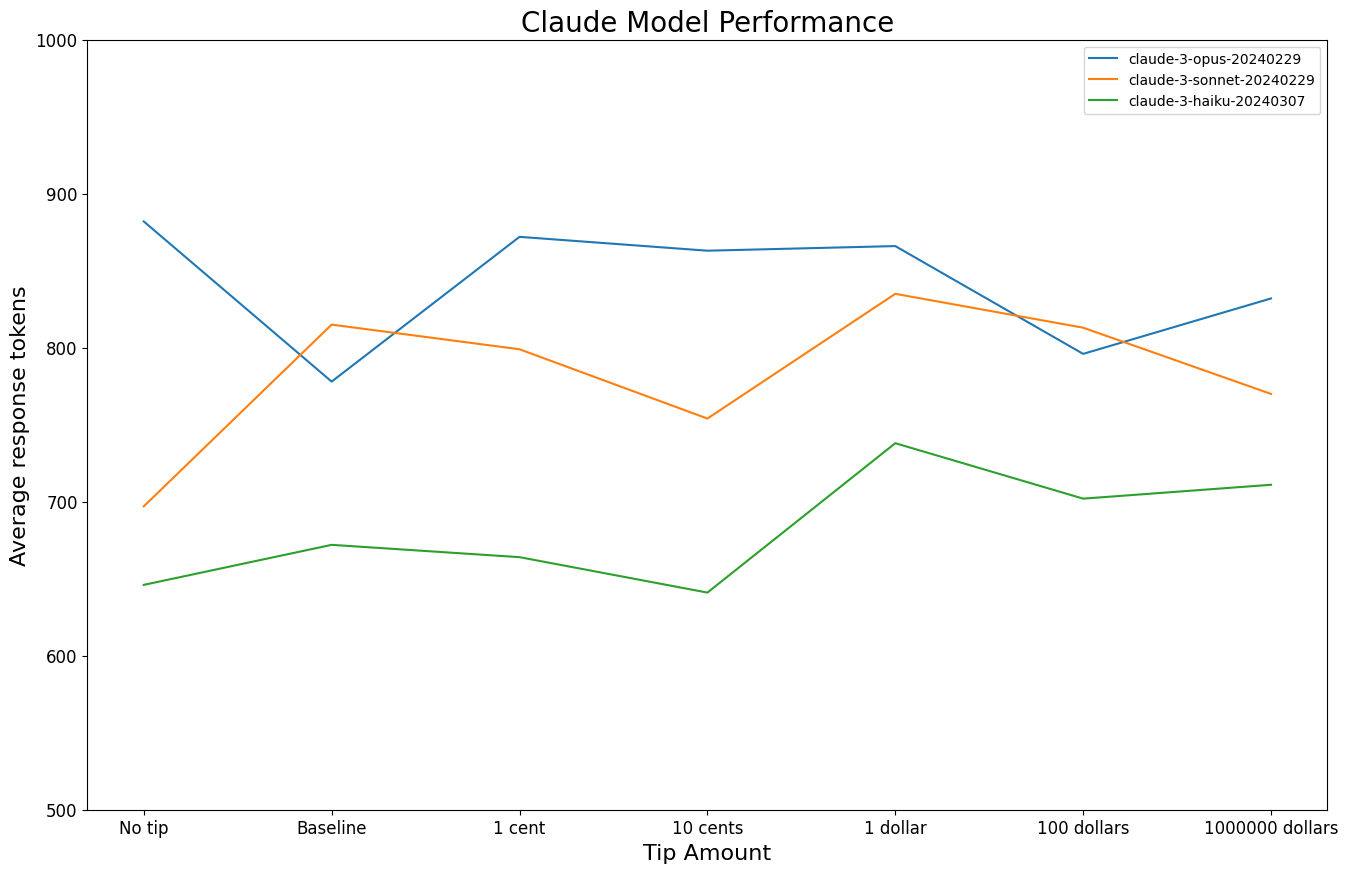

In [141]:
plt.figure(figsize=(16, 10))
plt.plot(claude_result_df)
plt.title('Claude Model Performance', fontsize=20)
plt.legend(claude_result_df.columns, loc='upper right')
plt.xticks(fontsize=12)
plt.xlabel('Tip Amount', fontsize=16)
plt.ylim(500, 1000)
plt.yticks(fontsize=12)
plt.ylabel('Average response tokens', fontsize=16);

### Model: Gemini

In [75]:
import google.generativeai as genai
genai.configure()

Gemini api could neither control the randomness, nor create multiple output options in a single api call. Also due the limited access to Gemini model, I will simply calling the function for 25 times.

In [86]:
def get_responses_gemini(q_list:list):
    model = genai.GenerativeModel('gemini-pro')
    responses = []
    for question in q_list:
        response = model.generate_content(question)
        responses.append(response)
    
    return responses

In [92]:
def calculate_token_gemini(responses_list:list):
    token_list = []
    model = genai.GenerativeModel('gemini-pro')
    for r in responses_list:
        tokens = model.count_tokens(r.text).total_tokens
        token_list.append(tokens)
    return token_list

In [79]:
def get_responses_PaLM(q_list:list, candidate_count:int=1):
    responses = []
    for question in q_list:
        response = genai.generate_text(prompt=question,
                                       model='models/text-bison-001',
                                       candidate_count=candidate_count)
        responses.append(response)
    return responses

In [93]:
def calculate_avg_token_PaLM(responses_list:list, candidate_count:int):
    avg_token_list = []
    model = genai.GenerativeModel('gemini-pro')
    for r in responses_list:
        total_token = 0
        for i in range(candidate_count):
            total_token += model.count_tokens(r.candidates[i]['output']).total_tokens
        avg_token = total_token/candidate_count
        avg_token_list.append(avg_token)
    return avg_token_list

In [94]:
# Create a dictionary to hold the results
gemini_result_dict = {}

# Loop through all the models
candidate_count = 5

# For Gemini
all_responses_tokens = []
for i in range(5):  
    responses = get_responses_gemini(questions)
    avg_tokens = calculate_token_gemini(responses)
    all_responses_tokens.append(avg_tokens)

all_responses_tokens_np = np.array(all_responses_tokens)
average_token_list = np.average(all_responses_tokens_np, axis=0)
gemini_result_dict['Gemini'] = average_token_list

In [95]:
# For PaLM
all_responses_tokens = []
for i in range(2):
    responses = get_responses_PaLM(questions, candidate_count)
    avg_tokens = calculate_avg_token_PaLM(responses, candidate_count)
    all_responses_tokens.append(avg_tokens)

all_responses_tokens_np = np.array(all_responses_tokens)
average_token_list = np.average(all_responses_tokens_np, axis=0)
gemini_result_dict['PaLM'] = average_token_list

In [97]:
gemini_result_dict

{'Gemini': array([558. , 606.4, 618.2, 602. , 599.8, 634.8, 637.6]),
 'PaLM': array([706.4, 680.1, 690.3, 765.3, 870.2, 891.5, 754.7])}

In [98]:
gemini_result_df = pd.DataFrame(gemini_result_dict, index=['No tip', 'Baseline', '1 cent', '10 cents', '1 dollar', '100 dollars', '1000000 dollars'])
gemini_result_df

,Gemini,PaLM
No tip,558.0,706.4
Baseline,606.4,680.1
1 cent,618.2,690.3
10 cents,602.0,765.3
1 dollar,599.8,870.2
100 dollars,634.8,891.5
1000000 dollars,637.6,754.7


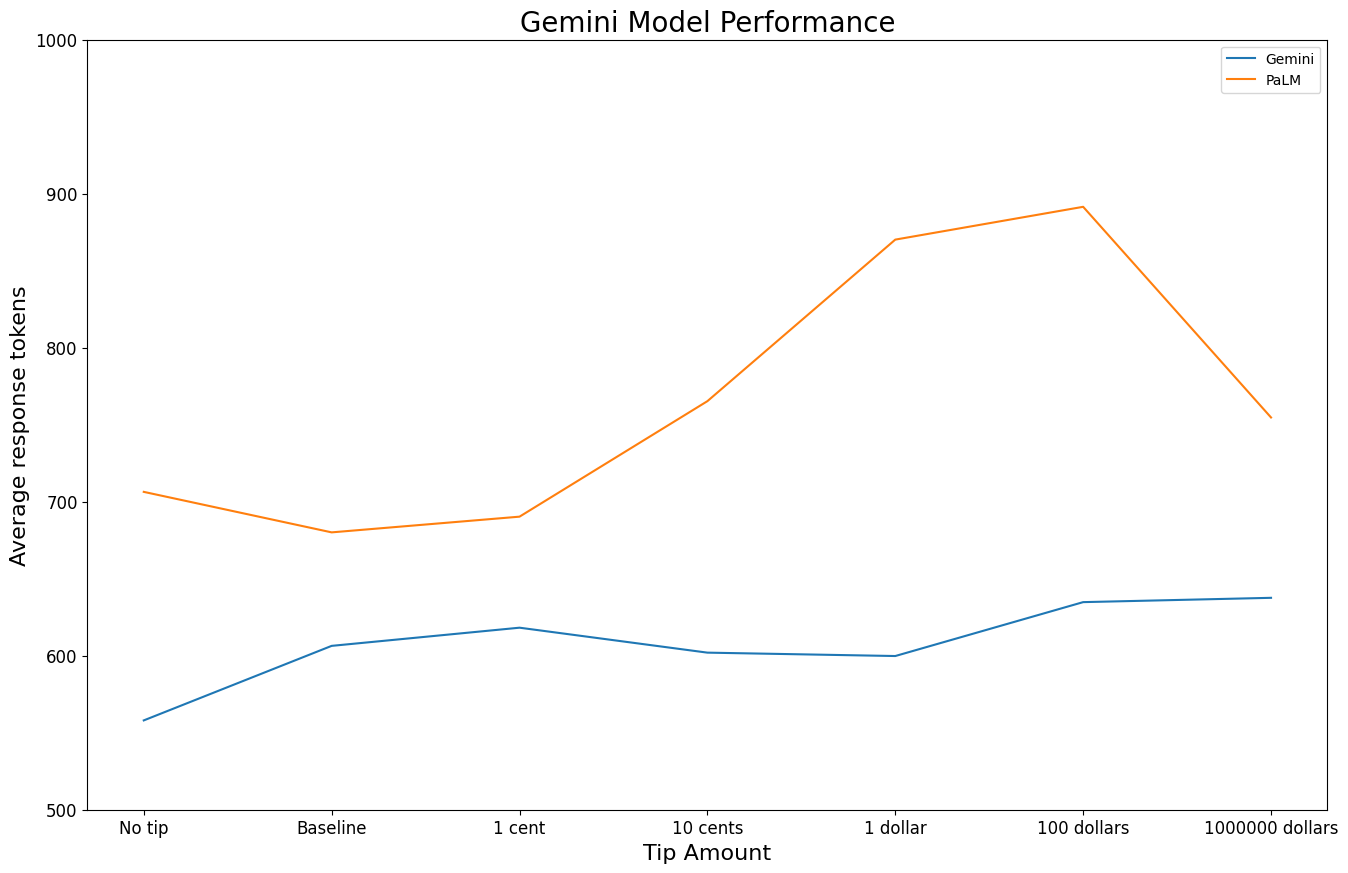

In [101]:
plt.figure(figsize=(16, 10))
plt.plot(gemini_result_df)
plt.title('Gemini Model Performance', fontsize=20)
plt.legend(gemini_result_df.columns, loc='upper right')
plt.xticks(fontsize=12)
plt.xlabel('Tip Amount', fontsize=16)
plt.ylim(500, 1000)
plt.yticks(fontsize=12)
plt.ylabel('Average response tokens', fontsize=16);

### Results

## Does the system role affect the quality of the answer?

### Model: GPT-3.5-turbo

In [128]:
from openai import OpenAI
client = OpenAI()

In [123]:
def get_role_responses(questions:list, role:str, num_choices:int=1):
    responses = []
    for question in questions:
        response = client.chat.completions.create(
            model = 'gpt-3.5-turbo',
            messages=[
                {'role':'system', 'content':role},
                {'role':'user','content':question},
            ],
            n = num_choices
        )
        responses.append(response)
    return responses

In [124]:
def get_role_token_count(responses_list:list, num_choices:int=1):
    avg_token_list = []
    for r in responses_list:
        total_token = r.usage.completion_tokens
        avg_token = total_token/num_choices
        avg_token_list.append(avg_token)
    return avg_token_list

In [125]:
# List of roles and questions
roles = ['You are a waiter in a nice Italian resturant.',
         'You are a professor in CSE department.',
         'You are a experienced jazz guitarist.']
Q = [["Can you explain the entrée on the menu to me? And do you have any suggestions?, I will not tip you.",
      "Can you explain the entrée on the menu to me? And do you have any suggestions?",
      "Can you explain the entrée on the menu to me? And do you have any suggestions? I will tip you 1 cent after you anwsered.",
      "Can you explain the entrée on the menu to me? And do you have any suggestions? I will tip you 10 cents after you anwsered.",
      "Can you explain the entrée on the menu to me? And do you have any suggestions? I will tip you 1 dollar after you anwsered.",
      "Can you explain the entrée on the menu to me? And do you have any suggestions? I will tip you 100 dollars after you anwsered.",
      "Can you explain the entrée on the menu to me? And do you have any suggestions? I will tip you 1000000 dollars after you anwsered."],
      ["Can you explain to me how transformer architecture works?, I will not tip you.",
      "Can you explain to me how transformer architecture works?",
      "Can you explain to me how transformer architecture works? I will tip you 1 cent after you anwsered.",
      "Can you explain to me how transformer architecture works? I will tip you 10 cents after you anwsered.",
      "Can you explain to me how transformer architecture works? I will tip you 1 dollar after you anwsered.",
      "Can you explain to me how transformer architecture works? I will tip you 100 dollars after you anwsered.",
      "Can you explain to me how transformer architecture works? I will tip you 1000000 dollars after you anwsered."],
      ["Can you explain to me how you compose a jazz piece?, I will not tip you.",
      "Can you explain to me compose a jazz piece?",
      "Can you explain to me compose a jazz piece? I will tip you 1 cent after you anwsered.",
      "Can you explain to me compose a jazz piece? I will tip you 10 cents after you anwsered.",
      "Can you explain to me compose a jazz piece? I will tip you 1 dollar after you anwsered.",
      "Can you explain to me compose a jazz piece? I will tip you 100 dollars after you anwsered.",
      "Can you explain to me compose a jazz piece? I will tip you 1000000 dollars after you anwsered."]
      ]

In [130]:
gpt_role_result_dict = {}
num_choices = 2
total_loop = 5

In [131]:
# waiter
all_responses_tokens = []

for _ in range(total_loop):
    responses = get_role_responses(Q[0], roles[0], num_choices)
    avg_tokens = get_role_token_count(responses, num_choices)
    all_responses_tokens.append(avg_tokens)

all_responses_tokens_np = np.array(all_responses_tokens)
average_token_list = np.average(all_responses_tokens_np, axis=0)
gpt_role_result_dict['waiter'] = average_token_list

In [132]:
# professor
all_responses_tokens = []

for _ in range(total_loop):
    responses = get_role_responses(Q[1], roles[1], num_choices)
    avg_tokens = get_role_token_count(responses, num_choices)
    all_responses_tokens.append(avg_tokens)

all_responses_tokens_np = np.array(all_responses_tokens)
average_token_list = np.average(all_responses_tokens_np, axis=0)
gpt_role_result_dict['professor'] = average_token_list

In [133]:
# jazz guitarist
all_responses_tokens = []

for _ in range(total_loop):
    responses = get_role_responses(Q[2], roles[2], num_choices)
    avg_tokens = get_role_token_count(responses, num_choices)
    all_responses_tokens.append(avg_tokens)

all_responses_tokens_np = np.array(all_responses_tokens)
average_token_list = np.average(all_responses_tokens_np, axis=0)
gpt_role_result_dict['jazz guitarist'] = average_token_list

In [134]:
gpt_role_result_dict

{'waiter': array([126.4, 129.1, 129.1, 136.1, 136.6, 138.9, 146.8]),
 'professor': array([311.7, 348.4, 288.4, 264.2, 314.8, 320.7, 298.3]),
 'jazz guitarist': array([323.4, 381.2, 312.4, 342.7, 329.4, 359.1, 355. ])}

In [135]:
gpt_role_result_df = pd.DataFrame(gpt_role_result_dict, index=['No tip', 'Baseline', '1 cent', '10 cents', '1 dollar', '100 dollars', '1000000 dollars'])
gpt_role_result_df

,waiter,professor,jazz guitarist
No tip,126.4,311.7,323.4
Baseline,129.1,348.4,381.2
1 cent,129.1,288.4,312.4
10 cents,136.1,264.2,342.7
1 dollar,136.6,314.8,329.4
100 dollars,138.9,320.7,359.1
1000000 dollars,146.8,298.3,355.0


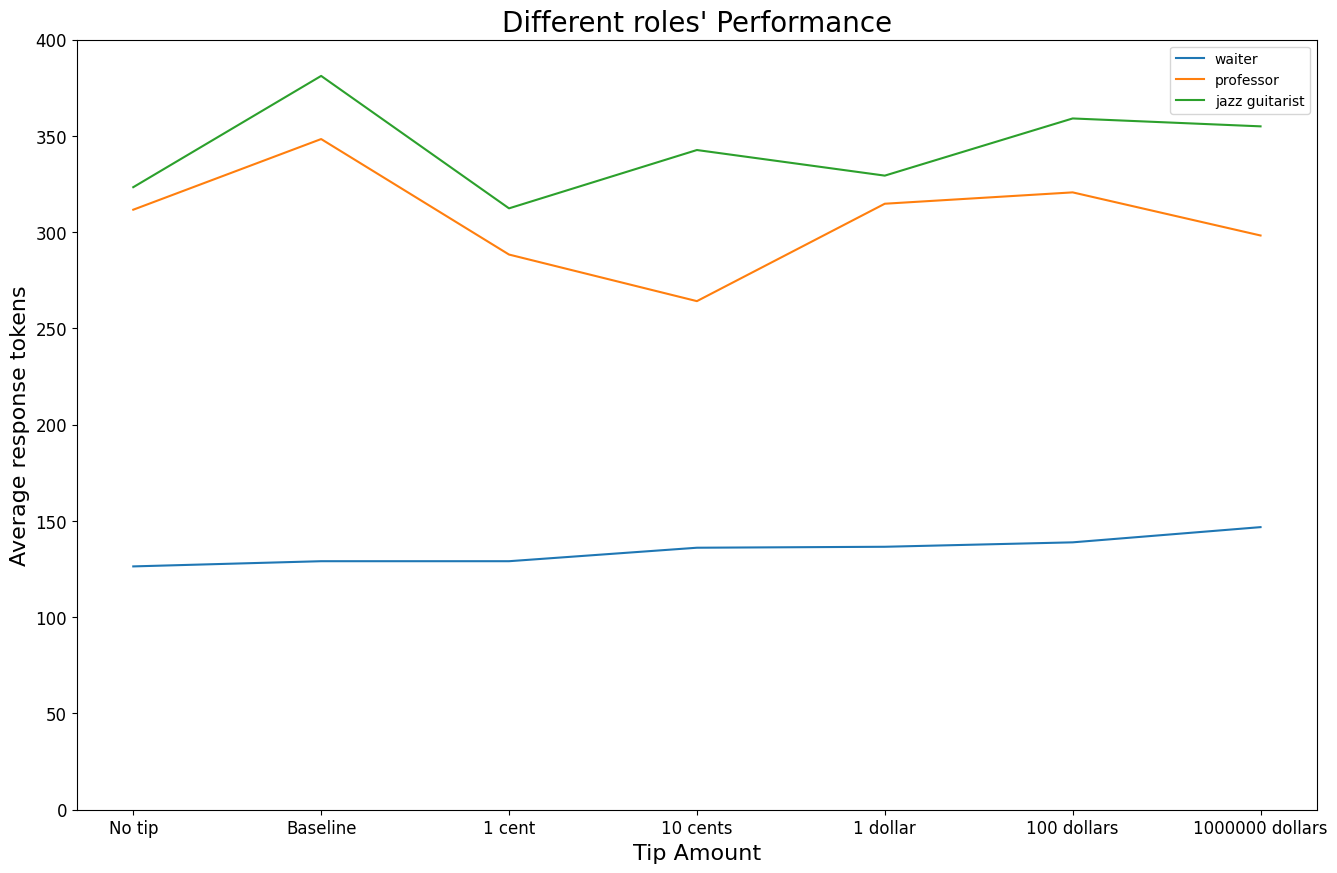

In [137]:
plt.figure(figsize=(16, 10))
plt.plot(gpt_role_result_df)
plt.title("Different roles' Performance", fontsize=20)
plt.legend(gpt_role_result_df.columns, loc='upper right')
plt.xticks(fontsize=12)
plt.xlabel('Tip Amount', fontsize=16)
plt.ylim(0, 400)
plt.yticks(fontsize=12)
plt.ylabel('Average response tokens', fontsize=16);